This notebook performs the synthesis using our proposed synthesization approach applied to the IPUMS data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools
import os
import pickle

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from sklearn.preprocessing import StandardScaler

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import standardized lat/long location data
train_data = pd.read_csv("../Data/IPUMS/cleaned_ipums_data.csv")

In [3]:
train_data

,incwage,years_of_educ,potential_experience,non_white,sex
0,9.305651,16.000000,18.000000,0,1
1,10.545341,15.000000,23.000000,0,0
2,8.853665,13.000000,2.000000,0,0
3,7.863267,11.000000,0.000000,0,0
4,9.942708,12.000000,33.000000,1,0
...,...,...,...,...,...
197751,10.021271,16.000000,13.000000,0,0
197752,8.411833,16.000000,11.000000,0,1
197753,10.518673,17.737673,19.262327,0,0
197754,7.313220,15.000000,13.000000,0,1


***

Functions for logistic and multinomial logistic regression synthesizer.

In [8]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_non_white_,
                    C_sex_):
    
    num_samples = train_data.shape[0]

    # normalized version of training data
    scaler = StandardScaler().fit(train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
    norm_train = train_data.copy()
    norm_train.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.transform(norm_train.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, covariance_type='full', init_params="k-means++", random_state=rng).fit(norm_train.loc[:,["incwage", "years_of_educ", "potential_experience"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ["incwage", "years_of_educ", "potential_experience"]
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for non-white MN ##########
    
    synth_non_white_vars = multinomial_synthesizer(orig_data=norm_train.loc[:,["incwage", "years_of_educ", "potential_experience"]], 
                                                   synth_data_sets=sXs, 
                                                   target=norm_train.non_white, 
                                                   penalty_param=C_non_white_)
    
    sXs = [pd.concat([Y, synth_non_white_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ########### Code for sex MN ##########
    
    synth_sex_vars = multinomial_synthesizer(orig_data=norm_train.loc[:,["incwage", "years_of_educ", "potential_experience", "non_white"]], 
                                             synth_data_sets=sXs, 
                                             target=norm_train.sex, 
                                             penalty_param=C_sex_)
    
    sXs = [pd.concat([Y, synth_sex_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(norm_train, Y) for Y in sXs]

        # convert sXs to original scale (un-normalize?)
    for i, Z in enumerate(sXs):
        H = train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:,['incwage', 'years_of_educ', 'potential_experience']]
        scaler = StandardScaler().fit(H)
        sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(Z.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
    
    return pmse_ratios, sXs, GMM

In [9]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       random_state):

    def evaluate_models(num_components_, C_non_white_, C_sex_):

        pmse_ratios, _, _ = train_models_mn(train_data=train_data,
                                            number_synthetic_datasets=number_synthetic_datasets,
                                            number_gmm_initializations=number_gmm_initializations,
                                            num_components_=int(num_components_),
                                            C_non_white_=C_non_white_,
                                            C_sex_=C_sex_)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "C_non_white_": (0.001, 3),
            "C_sex_": (0.001, 3)
        },
        random_state=random_state)
    
    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value for $\alpha = 1e-06$.

In [10]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [11]:
optimization_results = [optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   | C_non_... |  C_sex_   | num_co... |
-------------------------------------------------------------
| 1         | -1.621    | 2.23      | 0.68      | 132.7     |
| 2         | -2.836    | 2.647     | 2.222     | 147.8     |
| 3         | -933.1    | 0.8867    | 1.577     | 43.19     |
| 4         | -193.1    | 2.436     | 2.548     | 58.99     |
| 5         | -133.1    | 0.7125    | 1.376     | 53.72     |
| 6         | -6.732    | 2.405     | 1.326     | 139.0     |
| 7         | -177.5    | 0.001     | 0.001     | 154.5     |
| 8         | -1.654    | 0.04008   | 0.05111   | 143.2     |
| 9         | -70.71    | 0.001     | 3.0       | 123.9     |
| 10        | -112.6    | 3.0       | 0.001     | 110.2     |
| 11        | -94.9     | 0.001     | 3.0       | 95.25     |
| 12        | -66.31    | 2.832     | 0.09507   | 83.76     |
| 13        | -100.7    | 0.001     | 3.0       | 135.0     |
| 14        | -67.9     | 3.0       | 0.001     | 143.8     |
| 15    

In [12]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

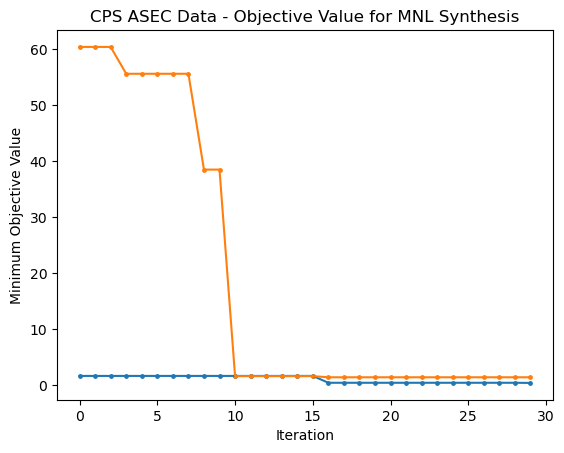

In [13]:
fig = plt.figure()
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("CPS ASEC Data - Objective Value for MNL Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
fig.savefig('../Images/min_objective_mnl_ipums.pdf')
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [14]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [15]:
best_params

{'target': -0.3713948106608193,
 'params': {'C_non_white_': 3.0,
  'C_sex_': 3.0,
  'num_components_': 163.21311998527037}}

Generate 20 synthetic data sets.

On occassion, the synthesis models will produce a significantly different fit than what was observed during the optimization process. In these cases, retrain the models until a fit (judged by the pMSE ratio) consistent with the optimization results is observed.

In [16]:
pmse_ratios, full_sXs, GMM = train_models_mn(train_data=train_data,
                                             number_synthetic_datasets=20,
                                             # hyperparameters for GMM
                                             number_gmm_initializations=ngi,
                                             num_components_=int(best_params['params']['num_components_']),
                                             # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                             C_non_white_=best_params['params']['C_non_white_'],
                                             C_sex_=best_params['params']['C_sex_'])

In [17]:
np.mean(pmse_ratios)

3.402033660158788

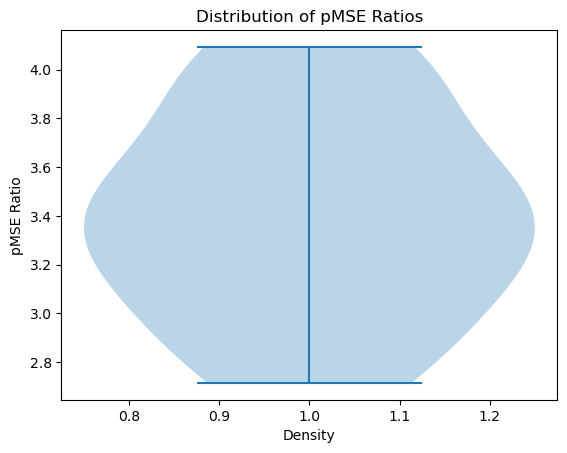

In [18]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

Save the GMM model.

In [19]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv", index=False)

# save
with open('../Results/IPUMS/Models/gmm_and_mnl.pkl','wb') as f:
    pickle.dump(GMM,f)

In [20]:
full_sXs = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]

# load
with open('../Results/IPUMS/Models/gmm_and_mnl.pkl', 'rb') as f:
    GMM = pickle.load(f)

***

Now apply the attribute disclosure prevention algorithm.

We don't have a great baseline for the probability of being non-white, so we'll just use the proportion from the data.

In [ ]:
prior = np.mean(train_data.non_white == 1)

In [ ]:
prior

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the non-white status based on the synthetic data. This is a relatively large increase. For example, this means going from XXX under the prior to no more than XXX under the updated probability.

In [ ]:
c = 3

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [ ]:
deltas = np.linspace(0.001, 0.1, 3)

In [ ]:
ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
                                         synthetic_data=X,
                                         continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
                                         categorical_vars=['sex'],
                                         sensitive_var='non_white',
                                         mixture_model=GMM,
                                         deltas=deltas, 
                                         c=c, 
                                         prior_prob=prior) for X in full_sXs]

In [ ]:
for i, sX in enumerate(ad_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/ad_gmm_and_mnl_" + str(i) + ".csv", index=False)